In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive

### Data Processing

In [20]:
scaler = StandardScaler()

In [21]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [22]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [23]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [24]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [26]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(1000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(200)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()

# df_rest_features

In [27]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [28]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [-0.99845873 -0.19304893 -1.32712824  0.38235582  0.95777022  1.82518362
 -0.81254723 -0.26106749 -0.14387596 -1.34296708 -1.56323362 -1.13899735
  0.08378457 -0.50377693]


In [29]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [30]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({5.0: 72,
         9.0: 131,
         1.0: 108,
         0.0: 148,
         10.0: 71,
         2.0: 103,
         7.0: 81,
         3.0: 122,
         8.0: 52,
         4.0: 53,
         6.0: 59})

In [31]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.062


### Model implementation with Pyro

In [32]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [33]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [34]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 19068.5
[1000] ELBO: 12284.8
[2000] ELBO: 7997.9
[3000] ELBO: 4925.9
[4000] ELBO: 3481.2
[5000] ELBO: 2488.8
[6000] ELBO: 2047.0
[7000] ELBO: 1843.6
[8000] ELBO: 1773.1
[9000] ELBO: 1726.8
[10000] ELBO: 1700.9
[11000] ELBO: 1691.5
[12000] ELBO: 1657.2
[13000] ELBO: 1658.5
[14000] ELBO: 1645.8
[15000] ELBO: 1637.8
[16000] ELBO: 1620.8
[17000] ELBO: 1633.2
[18000] ELBO: 1620.1
[19000] ELBO: 1617.1


In [36]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

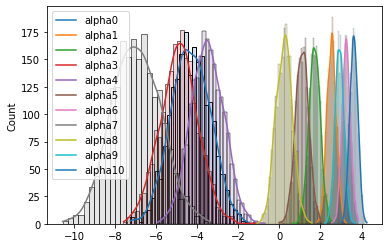

In [37]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

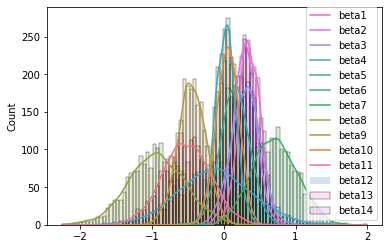

In [38]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [39]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

C:\Users\Nima\AppData\Local\Temp/ipykernel_16372/2012132113.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  mean_alpha = mean_alpha.T


### Inference and computation of accuracy on the train dataset 

In [40]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [7.70173383e-05 1.39915798e-01 4.80921998e-02 1.28005145e-06
 4.32704978e-04 5.95228423e-02 4.06131968e-01 1.49058370e-04
 1.07649305e-03 1.78807168e-01 1.65793469e-01] 6.0
n, p and y  1 [7.59432495e-05 1.71388666e-01 2.36884181e-02 1.08667910e-05
 4.26750119e-03 1.44171618e-02 1.36251181e-01 1.76383488e-06
 3.07746568e-02 1.38005975e-01 4.81117865e-01] 10.0
n, p and y  2 [3.72012555e-06 1.02991554e-01 4.29650979e-02 1.62562107e-05
 3.30843746e-05 3.60991383e-02 1.52265841e-01 7.40063897e-08
 1.18270074e-01 1.30943442e-01 4.16411718e-01] 10.0
n, p and y  3 [6.22201591e-05 6.44570242e-02 1.27746288e-01 6.19290950e-04
 9.16582329e-05 2.80786960e-02 2.14001193e-01 1.55637272e-06
 1.46213213e-02 1.94322908e-01 3.55997843e-01] 10.0
n, p and y  4 [1.91634145e-05 1.85614387e-01 4.83872446e-02 8.78932399e-05
 9.35993946e-05 1.90527854e-02 2.34762347e-01 1.31316971e-05
 5.90752671e-03 2.36171787e-01 2.69890134e-01] 10.0
n, p and y  5 [1.72465102e-07 2.38715817e-02 7.59527213e-04 8

n, p and y  83 [9.29139674e-05 2.47863118e-02 5.63638069e-03 8.40044200e-05
 3.83955824e-04 6.21112392e-01 7.08054368e-02 5.41395404e-06
 2.18821669e-04 2.52510980e-01 2.43633889e-02] 5.0
n, p and y  84 [1.59404927e-06 8.05323902e-02 2.79016545e-02 2.16325080e-05
 1.37301479e-05 4.15557672e-03 1.21389606e-01 2.34792663e-07
 1.73065281e-01 6.50509241e-02 5.27867376e-01] 10.0
n, p and y  85 [4.39393435e-05 1.34069728e-01 1.57861409e-02 2.15923167e-05
 6.21942634e-05 1.77548834e-02 4.11261859e-01 3.63940175e-04
 7.12615414e-03 1.62500191e-01 2.51009377e-01] 6.0
n, p and y  86 [8.62657380e-04 1.27181259e-01 8.21842946e-02 2.72477240e-05
 4.81134791e-03 8.93323002e-03 1.32223592e-01 1.28273876e-05
 1.17442127e-03 3.22567192e-01 3.20021931e-01] 9.0
n, p and y  87 [4.96360788e-06 1.79831466e-01 4.88878453e-02 2.79736807e-05
 7.43396388e-07 1.30517806e-03 2.04524486e-01 1.29897041e-06
 2.70789542e-02 7.61636446e-02 4.62173447e-01] 10.0
n, p and y  88 [5.70035916e-06 9.67301271e-02 2.39653725e-

n, p and y  170 [4.58145659e-06 1.31458696e-01 1.40552857e-02 1.80760004e-05
 7.91622102e-05 1.09427589e-03 1.04652300e-01 3.10605126e-07
 2.07672659e-01 2.33848607e-02 5.17579793e-01] 10.0
n, p and y  171 [2.47854639e-04 9.90790308e-02 3.75908117e-02 1.02890083e-05
 1.14813377e-03 3.23516383e-02 1.27255517e-01 2.43628842e-07
 1.12962985e-01 1.26743952e-01 4.62609543e-01] 10.0
n, p and y  172 [1.06412693e-04 3.83611717e-02 9.95914339e-03 4.80025117e-05
 1.65378002e-04 6.42689301e-03 9.45439962e-02 7.33913580e-07
 3.69420041e-01 4.66588578e-02 4.34309370e-01] 10.0
n, p and y  173 [0.01140808 0.04367604 0.12915461 0.37349323 0.00137584 0.00442713
 0.21746414 0.00313961 0.0011826  0.12596456 0.08871415] 3.0
n, p and y  174 [9.75968938e-06 1.83881808e-01 3.51065917e-02 2.39785379e-05
 1.12793490e-04 2.15687707e-02 1.42782774e-01 4.04010834e-08
 4.69779452e-02 8.47473990e-02 4.84788139e-01] 10.0
n, p and y  175 [7.51074700e-05 1.00883674e-01 9.86318672e-02 2.69861379e-03
 1.50779487e-06 1.8

n, p and y  257 [2.47301887e-05 1.29882927e-01 5.91675563e-02 1.70130188e-05
 1.05604161e-03 5.07997020e-02 1.67326066e-01 3.01783897e-07
 7.11419627e-02 1.08409015e-01 4.12174684e-01] 10.0
n, p and y  258 [1.18045951e-05 5.74400999e-02 1.49958927e-02 2.78748042e-05
 1.76737076e-06 3.04205839e-01 2.16754760e-01 6.29274924e-07
 4.99079649e-02 1.54525378e-01 2.02127990e-01] 5.0
n, p and y  259 [1.61507670e-03 6.62228943e-02 1.71789590e-02 2.26002401e-05
 7.33237337e-03 3.45860784e-02 1.23335637e-01 5.40942545e-05
 2.51625417e-04 5.82241250e-01 1.67159411e-01] 9.0
n, p and y  260 [3.66770941e-06 4.23735176e-02 1.90247798e-02 1.66343783e-06
 1.63284621e-05 1.57185872e-02 7.91787818e-02 8.88079277e-09
 4.44894711e-01 3.82635625e-02 3.60524392e-01] 8.0
n, p and y  261 [9.31811350e-06 5.74925038e-02 4.75995113e-03 4.77545522e-07
 1.76263616e-06 4.09983363e-02 2.90338696e-01 2.61247601e-06
 2.75848440e-01 3.40883665e-02 2.96459536e-01] 10.0
n, p and y  262 [3.43569863e-06 1.34116547e-01 4.2848

n, p and y  335 [6.75153132e-06 1.55973831e-01 1.25627907e-02 2.40311548e-06
 1.10803059e-05 1.21356487e-02 5.31902812e-01 3.23226569e-03
 6.15394423e-03 7.45917995e-02 2.03426673e-01] 6.0
n, p and y  336 [4.13598702e-05 1.08596188e-01 7.00632998e-02 6.37248894e-04
 3.30882829e-04 1.89216309e-02 1.79908400e-01 2.69431569e-06
 2.64480732e-02 1.90875142e-01 4.04175080e-01] 10.0
n, p and y  337 [1.10758813e-03 2.30772878e-02 6.11683608e-02 1.90771053e-03
 5.00577179e-05 2.69376269e-01 1.30037567e-01 6.12802556e-05
 3.96841269e-05 4.74410696e-01 3.87634994e-02] 9.0
n, p and y  338 [1.37181554e-05 1.90740532e-02 2.68086180e-03 9.31113334e-06
 3.86234638e-05 8.00832638e-01 4.83967376e-02 1.63431366e-07
 6.98839128e-04 1.02685378e-01 2.55696761e-02] 5.0
n, p and y  339 [1.02153176e-04 4.09815015e-02 1.12415693e-02 2.68168037e-03
 6.19801021e-05 8.05014405e-03 1.11980526e-01 3.71938587e-06
 3.76956825e-01 7.97948898e-02 3.68145011e-01] 8.0
n, p and y  340 [8.87813964e-07 1.42077689e-01 4.69321

n, p and y  413 [2.11672510e-06 7.51237702e-02 4.09307577e-02 1.77372400e-07
 1.94543140e-07 4.85900475e-02 4.86101759e-01 3.03120859e-06
 4.12186307e-02 4.73413674e-02 2.60688147e-01] 6.0
n, p and y  414 [1.40933143e-09 4.53861963e-02 4.49436394e-02 1.99514238e-09
 9.51195805e-09 6.17527042e-02 3.05520423e-01 1.92967506e-08
 3.05732903e-01 1.29911042e-02 2.23672998e-01] 8.0
n, p and y  415 [1.75083060e-04 5.45559404e-02 2.25536997e-02 1.35401538e-06
 6.57638284e-03 6.56832725e-02 1.03614225e-01 2.06665004e-06
 1.62745701e-03 5.10911463e-01 2.34299056e-01] 9.0
n, p and y  416 [1.85248460e-04 7.32170925e-02 1.97132652e-02 1.13557059e-04
 8.44004958e-04 2.75253626e-01 1.11120098e-01 4.04698633e-06
 6.69713912e-04 4.57210113e-01 6.16692338e-02] 9.0
n, p and y  417 [6.55694674e-04 8.34643123e-02 6.04332728e-02 1.02407266e-03
 7.24062080e-04 5.67793506e-03 1.43196919e-01 2.93312114e-06
 6.49345214e-02 9.58628155e-02 5.44023461e-01] 10.0
n, p and y  418 [1.29958160e-05 1.06124524e-01 7.65244

n, p and y  480 [8.45250800e-05 1.60394849e-01 3.78294068e-02 1.81675087e-03
 1.23395272e-05 1.00522363e-02 2.53901040e-01 6.20694700e-06
 1.70025410e-01 6.36789522e-02 3.02198283e-01] 10.0
n, p and y  481 [7.76326158e-05 9.99518477e-02 4.94169166e-01 1.03332076e-04
 6.00603609e-05 1.85529456e-02 1.46330099e-01 1.34053355e-07
 9.50233170e-03 5.18759629e-02 1.79376488e-01] 2.0
n, p and y  482 [1.38869131e-07 9.74664384e-03 1.02160046e-03 6.62642796e-07
 6.59787202e-07 6.52971528e-03 2.45123650e-02 4.66946926e-09
 7.91568499e-01 1.78984662e-02 1.48721244e-01] 8.0
n, p and y  483 [3.96855249e-05 5.81942451e-02 1.74225473e-01 4.99898051e-05
 9.10308217e-05 2.05912074e-02 1.83172651e-01 2.41775126e-06
 2.92562196e-03 2.60213803e-01 3.00493875e-01] 10.0
n, p and y  484 [0.01136111 0.09601871 0.03206304 0.01471329 0.07216912 0.01002488
 0.1836768  0.00312104 0.00195728 0.34034617 0.23454855] 9.0
n, p and y  485 [2.17454057e-06 8.43234017e-02 6.06788412e-02 1.37561665e-06
 9.57478831e-06 3.306

n, p and y  560 [1.06801095e-06 4.75480998e-02 5.50044185e-03 6.82662172e-07
 4.79026269e-06 4.29972908e-04 3.09861444e-02 3.28280390e-09
 5.67019304e-01 5.03247847e-03 3.43477014e-01] 8.0
n, p and y  561 [1.48477684e-06 9.10045721e-02 1.54041031e-01 2.88737374e-08
 5.89941980e-07 2.79968657e-03 5.35738952e-01 1.80681310e-04
 9.00289045e-04 5.22955481e-03 2.10103130e-01] 6.0
n, p and y  562 [3.20439713e-06 2.21461129e-01 4.35923722e-02 1.35911164e-05
 5.20339588e-05 3.19101947e-02 5.81029144e-01 5.66720684e-03
 6.40132877e-04 3.57669047e-02 7.98640855e-02] 6.0
n, p and y  563 [4.82791959e-06 2.06231399e-02 3.35286061e-03 1.72991257e-06
 2.18111075e-05 3.31545906e-02 4.89116060e-02 1.22649452e-08
 6.10098860e-01 3.51359026e-02 2.48694659e-01] 8.0
n, p and y  564 [2.82245347e-06 1.39681032e-01 3.38768352e-02 2.34917742e-06
 1.80035345e-04 2.03947601e-02 1.47346406e-01 5.82154352e-08
 2.10783643e-02 1.42335102e-01 4.95102235e-01] 10.0
n, p and y  565 [9.33244999e-03 4.50274216e-02 1.25326

n, p and y  643 [3.64556011e-05 1.35108412e-01 5.36726011e-02 1.09730946e-05
 3.23522159e-03 2.89297591e-02 1.54531765e-01 1.42817536e-06
 5.39646276e-03 2.23669493e-01 3.95407428e-01] 10.0
n, p and y  644 [1.35169853e-09 5.42545858e-02 2.51371132e-01 5.31135263e-07
 4.15647685e-08 1.99825032e-03 9.52826920e-02 3.78618281e-10
 1.52520943e-01 1.07926245e-02 4.33779198e-01] 10.0
n, p and y  645 [3.22338723e-06 6.74740868e-02 1.88825065e-02 2.75514313e-06
 2.35300237e-05 1.22175501e-02 1.33227719e-01 1.85835202e-07
 1.28545507e-01 1.07012462e-01 5.32610475e-01] 10.0
n, p and y  646 [7.19873337e-06 2.02126508e-01 3.42738380e-02 4.28436684e-05
 1.02371683e-04 1.17634893e-02 1.68115268e-01 2.25315436e-07
 1.77338764e-01 3.70006481e-02 3.69228846e-01] 10.0
n, p and y  647 [1.64878600e-03 9.27913321e-02 6.64536528e-02 1.17467617e-04
 3.50270216e-03 4.62132218e-02 1.41655953e-01 2.28165044e-05
 1.21526239e-04 5.52069210e-01 9.54033314e-02] 9.0
n, p and y  648 [2.31624245e-02 4.02169547e-02 6.45

n, p and y  722 [1.03853960e-05 6.59330050e-02 2.98990780e-01 1.82064718e-06
 6.13864273e-07 7.27730997e-03 2.56063302e-01 1.86551457e-07
 3.19928176e-02 1.93642666e-02 3.20365513e-01] 10.0
n, p and y  723 [1.45797836e-05 2.96446375e-02 4.27135496e-03 1.18955648e-06
 1.49341264e-04 1.38959575e-02 5.29689323e-02 5.50127145e-08
 5.15553040e-01 4.06500627e-02 3.42850849e-01] 8.0
n, p and y  724 [3.87692124e-06 5.13456372e-02 1.02191485e-02 4.91114095e-07
 2.20103334e-05 1.58157106e-02 6.67644728e-02 6.81972465e-09
 4.47835866e-01 3.48052965e-02 3.73187483e-01] 8.0
n, p and y  725 [6.05719415e-05 7.11594885e-02 1.13359358e-02 2.42746392e-05
 4.66098408e-04 9.93342383e-03 9.16600637e-02 4.95047231e-07
 4.08200287e-01 3.42702960e-02 3.72889065e-01] 8.0
n, p and y  726 [1.10816030e-11 3.03693644e-02 9.58078936e-03 5.78789563e-13
 1.97726322e-10 1.16760099e-02 1.19958567e-01 6.45418651e-11
 5.66018467e-01 1.22006992e-03 2.61176732e-01] 8.0
n, p and y  727 [1.03802089e-07 1.02573872e-01 6.09892

n, p and y  796 [1.37165481e-02 2.18513949e-02 2.36309369e-03 2.73289195e-03
 6.98811491e-01 3.67391194e-03 2.88783778e-02 2.88012004e-04
 1.80830220e-03 1.46888229e-01 7.89877471e-02] 4.0
n, p and y  797 [9.25152512e-09 1.01697721e-02 2.37166860e-03 2.28698001e-07
 6.00304658e-08 4.76577431e-01 7.19612140e-02 1.63543648e-09
 2.44450746e-01 6.06131098e-02 1.33855758e-01] 5.0
n, p and y  798 [2.07770201e-02 5.36785070e-02 3.56073642e-01 6.87451054e-03
 8.37177768e-03 2.37596957e-02 1.24792908e-01 1.09806256e-04
 3.27207387e-06 3.64908806e-01 4.06500540e-02] 9.0
n, p and y  799 [1.82346975e-01 1.56881332e-02 2.49130154e-02 1.22919399e-01
 5.16889998e-01 8.65710839e-04 1.91431965e-02 4.28044062e-03
 1.01454393e-06 1.03056702e-01 9.89541491e-03] 4.0
n, p and y  800 [7.66443748e-02 9.11225557e-03 5.53258041e-02 6.06988742e-01
 1.66683370e-02 4.12859172e-03 3.04308618e-02 2.64761954e-04
 7.78131485e-06 1.87648322e-01 1.27801670e-02] 3.0
n, p and y  801 [3.94606029e-06 3.36393880e-02 3.061354

n, p and y  874 [1.71469903e-09 1.42288156e-02 5.21108986e-04 1.13899149e-10
 3.12587672e-09 1.41303849e-04 3.10481737e-02 3.79097439e-09
 7.90419879e-01 5.00501421e-04 1.63140208e-01] 8.0
n, p and y  875 [2.19866451e-05 6.65909472e-02 4.01023815e-03 5.77050241e-07
 2.07422109e-03 6.81161571e-03 5.92030163e-02 1.26155102e-07
 1.68864532e-01 7.45248398e-02 6.17897900e-01] 10.0
n, p and y  876 [5.19038557e-08 1.61270665e-01 7.40801169e-02 1.02708989e-07
 1.55166509e-05 1.69425523e-03 1.11976699e-01 3.81002712e-08
 3.67610119e-02 1.71140747e-02 5.97087468e-01] 10.0
n, p and y  877 [1.06425970e-03 8.90332871e-02 3.18896643e-01 1.52171999e-03
 8.69516439e-06 2.88173179e-03 1.71101093e-01 1.50854103e-05
 1.17268359e-04 2.65441546e-01 1.49918671e-01] 2.0
n, p and y  878 [5.72552188e-11 3.68530623e-02 1.63338589e-02 4.37052114e-10
 3.39066190e-09 7.51684204e-03 4.65046487e-02 7.90852095e-12
 5.46734365e-01 3.55542871e-03 3.42501791e-01] 8.0
n, p and y  879 [7.42026421e-05 6.67438165e-02 9.1793

n, p and y  952 [8.92875613e-07 2.13021528e-02 2.78793392e-03 4.11529299e-05
 1.86277784e-06 7.08548256e-01 8.59585822e-02 2.94586723e-07
 4.71223410e-03 1.30963044e-01 4.56835943e-02] 5.0
n, p and y  953 [8.53297240e-07 8.15303460e-02 9.66212014e-03 1.79098667e-08
 2.32324051e-05 6.93811183e-03 7.03579579e-02 6.08266211e-09
 1.51150898e-01 5.58339888e-02 6.24502467e-01] 10.0
n, p and y  954 [3.39376149e-05 9.23093244e-02 9.22342048e-03 2.04355882e-07
 1.26762195e-03 5.94633357e-02 1.42637985e-01 9.63125398e-07
 5.23064936e-02 1.88541923e-01 4.54214791e-01] 10.0
n, p and y  955 [1.73425719e-07 1.17521732e-01 1.59450531e-01 3.53900977e-08
 9.25143090e-09 6.13042704e-02 5.33171012e-01 1.08083785e-06
 2.24702582e-04 5.51361165e-02 7.31903375e-02] 6.0
n, p and y  956 [2.78171721e-03 9.04084339e-02 4.68315625e-02 7.63561541e-04
 5.24613666e-03 2.24150961e-02 1.57062412e-01 5.87889544e-06
 1.06674630e-01 1.59683016e-01 4.08127555e-01] 10.0
n, p and y  957 [5.32276749e-04 8.39792745e-02 4.493

In [41]:
y_train_pred = y_train_pred[:,0]

In [42]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.516


### Inference and computation of accuracy on the test dataset 

In [43]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [6.56474353e-06 9.24652121e-02 2.14510406e-02 2.31887167e-06
 1.73843753e-04 1.73012413e-02 1.19037878e-01 1.13318954e-07
 1.11677013e-01 1.27091032e-01 5.10793743e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  1 [3.14046493e-09 1.39583134e-02 4.77195387e-03 5.47166977e-09
 1.71790753e-09 9.68619512e-04 2.52819362e-02 4.16646317e-11
 8.40125293e-01 1.67191798e-03 1.13221956e-01] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  2 [6.04156260e-07 5.53752714e-02 2.78808476e-03 7.10982246e-08
 1.13528915e-06 2.06554671e-01 3.77551294e-01 9.01726079e-06
 7.36313048e-02 1.02922166e-01 1.81166380e-01] [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
n, p and y  3 [3.06457019e-07 5.50169803e-02 5.22437998e-03 2.12681439e-07
 8.13882495e-06 3.47588221e-01 1.24201762e-01 4.39380432e-08
 4.75348737e-02 1.75201550e-01 2.45223531e-01] [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
n, p and y  4 [6.54516784e-04 5.70619778e-04 3.66614297e-05 1.21262999e-04
 2.54727539e-05 8.11578214e-06 3.28945097e

n, p and y  72 [2.17684719e-02 1.30061583e-03 2.73203846e-03 8.39030133e-01
 4.57322775e-05 1.02490931e-01 8.81313349e-03 5.78118858e-04
 4.21299516e-08 2.30076290e-02 2.33153770e-04] [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
n, p and y  73 [1.00166096e-05 1.23618411e-01 1.24442893e-02 6.45167938e-06
 8.95475013e-06 3.17277235e-03 2.91096496e-01 3.75768333e-06
 6.58880956e-02 2.80400253e-02 4.75710730e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  74 [3.14137248e-05 6.57592414e-02 2.05341303e-02 2.21050344e-06
 2.34835485e-04 1.20513255e-02 1.09712384e-01 4.09464535e-07
 6.86610357e-02 7.73297200e-02 6.45683293e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  75 [2.51667117e-04 4.15179613e-02 1.03876710e-02 2.29333742e-05
 4.21863026e-04 5.64966339e-02 1.12979691e-01 6.06428356e-06
 3.19163220e-02 4.96223615e-01 2.49775578e-01] [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
n, p and y  76 [2.46612358e-04 3.02185803e-02 2.75235946e-02 9.82873318e-04
 5.94042235e-05 3.49682861

n, p and y  153 [7.91380746e-04 3.42277349e-02 5.37123339e-01 4.39623381e-03
 3.77835772e-04 6.44537587e-03 1.56430061e-01 4.51480429e-06
 3.34527679e-03 6.75846321e-02 1.89273616e-01] [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
n, p and y  154 [7.92139346e-07 3.82760663e-02 2.11821948e-02 1.56869780e-05
 4.73279871e-07 3.29229126e-01 1.48176634e-01 1.07500890e-08
 7.69352738e-02 1.34454341e-01 2.51729400e-01] [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
n, p and y  155 [1.40082500e-04 1.15654130e-02 1.57400196e-02 7.88830248e-05
 2.69873319e-06 7.12185472e-01 6.16841137e-02 4.57990519e-07
 2.06096927e-05 1.84485919e-01 1.40963307e-02] [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
n, p and y  156 [1.63458213e-06 7.09725217e-02 1.42569361e-02 6.84548978e-06
 4.77299410e-06 3.72982913e-03 8.48278106e-02 4.39056576e-08
 3.32466935e-01 2.92472837e-02 4.64485387e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  157 [7.86604046e-05 1.13349525e-01 1.12035383e-02 1.81013141e-07
 3.76931791e-04 4.27470510e-02 3

In [44]:
y_test_pred = y_test_pred[:,0]

In [45]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.54



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 

TODO

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Consider different distributions for priors
* Train model on more data - currently 100 
* Extend it with FFNN 
* Feature engineer name and album name and retrain logistic regression model using these attributes